In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

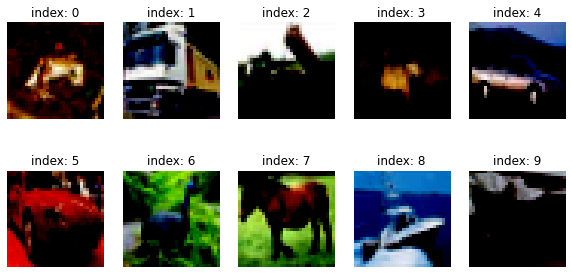

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = np.float32((train_data - 127.5) / 127.5)
test_data = np.float32((test_data - 127.5) / 127.5)

from PIL import Image
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()


In [3]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   
            new_t_labels.append([0])  
        else:
            new_t_labels.append([1]) 
             
    return np.array(new_t_labels)

In [4]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [5]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [6]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [7]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [8]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [9]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [10]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [13]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [14]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [15]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [16]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

In [17]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [18]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

In [19]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [20]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [21]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [22]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

In [23]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [24]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
max_epochs = 25
steps = 0
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 13.746088981628418, 	 Total Dis Loss : 0.6942284107208252
Steps : 200, 	 Total Gen Loss : 15.437246322631836, 	 Total Dis Loss : 0.606779932975769
Steps : 300, 	 Total Gen Loss : 14.291644096374512, 	 Total Dis Loss : 0.4224868714809418
Steps : 400, 	 Total Gen Loss : 18.559110641479492, 	 Total Dis Loss : 0.3569354712963104
Steps : 500, 	 Total Gen Loss : 17.265804290771484, 	 Total Dis Loss : 0.37915724515914917
Steps : 600, 	 Total Gen Loss : 20.16524314880371, 	 Total Dis Loss : 0.04737061262130737
Steps : 700, 	 Total Gen Loss : 17.652210235595703, 	 Total Dis Loss : 0.0325196273624897
Steps : 800, 	 Total Gen Loss : 18.10719871520996, 	 Total Dis Loss : 0.40460991859436035
Steps : 900, 	 Total Gen Loss : 17.344730377197266, 	 Total Dis Loss : 0.050973616540431976
Steps : 1000, 	 Total Gen Loss : 22.611167907714844, 	 Total Dis Loss : 0.15796604752540588
Steps : 1100, 	 Total Gen Loss : 19.7985782623291, 	 Total Dis Loss : 0.0850161612033844
Steps :

Steps : 9000, 	 Total Gen Loss : 20.558277130126953, 	 Total Dis Loss : 0.006378630641847849
Steps : 9100, 	 Total Gen Loss : 23.461219787597656, 	 Total Dis Loss : 0.004712411668151617
Steps : 9200, 	 Total Gen Loss : 22.250539779663086, 	 Total Dis Loss : 0.007655436173081398
Steps : 9300, 	 Total Gen Loss : 23.267866134643555, 	 Total Dis Loss : 0.0016494439914822578
Steps : 9400, 	 Total Gen Loss : 23.07807159423828, 	 Total Dis Loss : 0.017534814774990082
Steps : 9500, 	 Total Gen Loss : 23.04981803894043, 	 Total Dis Loss : 0.009268688037991524
Steps : 9600, 	 Total Gen Loss : 27.117456436157227, 	 Total Dis Loss : 0.0025168824940919876
Steps : 9700, 	 Total Gen Loss : 21.942214965820312, 	 Total Dis Loss : 0.0054158903658390045
Steps : 9800, 	 Total Gen Loss : 24.465974807739258, 	 Total Dis Loss : 0.005236579570919275
Steps : 9900, 	 Total Gen Loss : 23.179306030273438, 	 Total Dis Loss : 0.0051703439094126225
Steps : 10000, 	 Total Gen Loss : 25.44211196899414, 	 Total Dis Los

Steps : 17700, 	 Total Gen Loss : 24.428205490112305, 	 Total Dis Loss : 0.0005231931572780013
Steps : 17800, 	 Total Gen Loss : 24.0782527923584, 	 Total Dis Loss : 0.00019512567087076604
Steps : 17900, 	 Total Gen Loss : 25.609130859375, 	 Total Dis Loss : 0.0006717729847878218
Steps : 18000, 	 Total Gen Loss : 23.30072784423828, 	 Total Dis Loss : 0.0009864564053714275
Steps : 18100, 	 Total Gen Loss : 23.038890838623047, 	 Total Dis Loss : 0.0006299753440544009
Steps : 18200, 	 Total Gen Loss : 25.773956298828125, 	 Total Dis Loss : 0.0009026775369420648
Steps : 18300, 	 Total Gen Loss : 27.178234100341797, 	 Total Dis Loss : 0.0005426228162832558
Steps : 18400, 	 Total Gen Loss : 24.579864501953125, 	 Total Dis Loss : 0.0005084158619865775
Steps : 18500, 	 Total Gen Loss : 24.412979125976562, 	 Total Dis Loss : 0.0014656669227406383
Steps : 18600, 	 Total Gen Loss : 25.453413009643555, 	 Total Dis Loss : 0.0012642114888876677
Steps : 18700, 	 Total Gen Loss : 27.34876251220703, 	 

Steps : 26400, 	 Total Gen Loss : 23.069135665893555, 	 Total Dis Loss : 0.0004154187045060098
Steps : 26500, 	 Total Gen Loss : 24.660154342651367, 	 Total Dis Loss : 0.0004098587669432163
Steps : 26600, 	 Total Gen Loss : 26.574722290039062, 	 Total Dis Loss : 0.00036978587741032243
Steps : 26700, 	 Total Gen Loss : 28.221683502197266, 	 Total Dis Loss : 0.001193790347315371
Steps : 26800, 	 Total Gen Loss : 24.54084587097168, 	 Total Dis Loss : 0.0014888443984091282
Steps : 26900, 	 Total Gen Loss : 20.75133514404297, 	 Total Dis Loss : 0.0059155672788619995
Steps : 27000, 	 Total Gen Loss : 22.94601058959961, 	 Total Dis Loss : 0.0007675890810787678
Steps : 27100, 	 Total Gen Loss : 22.64274024963379, 	 Total Dis Loss : 0.0012250072322785854
Steps : 27200, 	 Total Gen Loss : 22.53842544555664, 	 Total Dis Loss : 0.00033109437208622694
Steps : 27300, 	 Total Gen Loss : 22.115615844726562, 	 Total Dis Loss : 0.00029091699980199337
Steps : 27400, 	 Total Gen Loss : 22.66779136657715, 

Steps : 35000, 	 Total Gen Loss : 26.34208106994629, 	 Total Dis Loss : 0.0014917835360392928
Steps : 35100, 	 Total Gen Loss : 24.947813034057617, 	 Total Dis Loss : 0.0004899410414509475
Steps : 35200, 	 Total Gen Loss : 27.8383731842041, 	 Total Dis Loss : 0.0003534152056090534
Steps : 35300, 	 Total Gen Loss : 27.022891998291016, 	 Total Dis Loss : 0.0003405017778277397
Steps : 35400, 	 Total Gen Loss : 23.20978546142578, 	 Total Dis Loss : 0.00034916435834020376
Steps : 35500, 	 Total Gen Loss : 25.49427032470703, 	 Total Dis Loss : 0.00023587647592648864
Steps : 35600, 	 Total Gen Loss : 27.680450439453125, 	 Total Dis Loss : 0.00020693294936791062
Steps : 35700, 	 Total Gen Loss : 28.55379295349121, 	 Total Dis Loss : 0.00014276852016337216
Steps : 35800, 	 Total Gen Loss : 27.010494232177734, 	 Total Dis Loss : 0.00013310190115589648
Steps : 35900, 	 Total Gen Loss : 28.183895111083984, 	 Total Dis Loss : 5.660526949213818e-05
Steps : 36000, 	 Total Gen Loss : 30.65747451782226

Steps : 43700, 	 Total Gen Loss : 29.732919692993164, 	 Total Dis Loss : 0.00033132312819361687
Steps : 43800, 	 Total Gen Loss : 29.23515510559082, 	 Total Dis Loss : 0.0004702288133557886
Steps : 43900, 	 Total Gen Loss : 24.971927642822266, 	 Total Dis Loss : 0.0010297037661075592
Steps : 44000, 	 Total Gen Loss : 24.92984390258789, 	 Total Dis Loss : 0.0003476319834589958
Steps : 44100, 	 Total Gen Loss : 25.83761215209961, 	 Total Dis Loss : 0.006876570172607899
Steps : 44200, 	 Total Gen Loss : 25.744537353515625, 	 Total Dis Loss : 0.005297509487718344
Steps : 44300, 	 Total Gen Loss : 30.654672622680664, 	 Total Dis Loss : 0.0015495517291128635
Steps : 44400, 	 Total Gen Loss : 28.418212890625, 	 Total Dis Loss : 0.0007111721788533032
Steps : 44500, 	 Total Gen Loss : 25.850296020507812, 	 Total Dis Loss : 0.00025036773877218366
Steps : 44600, 	 Total Gen Loss : 24.729991912841797, 	 Total Dis Loss : 0.011909565888345242
Steps : 44700, 	 Total Gen Loss : 24.53171157836914, 	 To

Steps : 52300, 	 Total Gen Loss : 24.658222198486328, 	 Total Dis Loss : 0.00019957787299063057
Steps : 52400, 	 Total Gen Loss : 24.385356903076172, 	 Total Dis Loss : 0.010450679808855057
Steps : 52500, 	 Total Gen Loss : 24.834510803222656, 	 Total Dis Loss : 0.0020495299249887466
Steps : 52600, 	 Total Gen Loss : 25.30573272705078, 	 Total Dis Loss : 0.0002461056283209473
Steps : 52700, 	 Total Gen Loss : 24.898208618164062, 	 Total Dis Loss : 0.00015822112618479878
Steps : 52800, 	 Total Gen Loss : 26.805973052978516, 	 Total Dis Loss : 0.0007295126561075449
Steps : 52900, 	 Total Gen Loss : 25.35552978515625, 	 Total Dis Loss : 0.0005635962006635964
Steps : 53000, 	 Total Gen Loss : 27.172821044921875, 	 Total Dis Loss : 7.483144872821867e-05
Steps : 53100, 	 Total Gen Loss : 29.258495330810547, 	 Total Dis Loss : 0.0004546573618426919
Steps : 53200, 	 Total Gen Loss : 24.55353355407715, 	 Total Dis Loss : 0.00039432093035429716
Steps : 53300, 	 Total Gen Loss : 28.41571235656738

Steps : 61000, 	 Total Gen Loss : 26.531221389770508, 	 Total Dis Loss : 0.0015355389332398772
Steps : 61100, 	 Total Gen Loss : 23.2108154296875, 	 Total Dis Loss : 0.00021423505677375942
Steps : 61200, 	 Total Gen Loss : 25.581375122070312, 	 Total Dis Loss : 0.0009969144593924284
Steps : 61300, 	 Total Gen Loss : 23.550020217895508, 	 Total Dis Loss : 0.0009466881165280938
Steps : 61400, 	 Total Gen Loss : 26.522096633911133, 	 Total Dis Loss : 0.00017157096590381116
Steps : 61500, 	 Total Gen Loss : 24.73145294189453, 	 Total Dis Loss : 0.00018042181909549981
Steps : 61600, 	 Total Gen Loss : 21.79800033569336, 	 Total Dis Loss : 0.0004387536318972707
Steps : 61700, 	 Total Gen Loss : 23.279762268066406, 	 Total Dis Loss : 0.00035292329266667366
Steps : 61800, 	 Total Gen Loss : 23.029354095458984, 	 Total Dis Loss : 0.0001896828762255609
Time for epoch 11 is 342.87165880203247 sec
Steps : 61900, 	 Total Gen Loss : 24.088294982910156, 	 Total Dis Loss : 0.0027740211226046085
Steps 

Steps : 69600, 	 Total Gen Loss : 25.095138549804688, 	 Total Dis Loss : 2.005381611525081e-05
Steps : 69700, 	 Total Gen Loss : 27.438058853149414, 	 Total Dis Loss : 5.158409840078093e-05
Steps : 69800, 	 Total Gen Loss : 24.652158737182617, 	 Total Dis Loss : 7.463717338396236e-05
Steps : 69900, 	 Total Gen Loss : 25.379165649414062, 	 Total Dis Loss : 7.4651965405792e-05
Steps : 70000, 	 Total Gen Loss : 24.574350357055664, 	 Total Dis Loss : 0.0002260303299408406
Steps : 70100, 	 Total Gen Loss : 25.050832748413086, 	 Total Dis Loss : 0.00029624448507092893
Steps : 70200, 	 Total Gen Loss : 27.469202041625977, 	 Total Dis Loss : 3.32648451148998e-05
Steps : 70300, 	 Total Gen Loss : 23.77355194091797, 	 Total Dis Loss : 8.408846770180389e-05
Steps : 70400, 	 Total Gen Loss : 26.774721145629883, 	 Total Dis Loss : 0.00010127506538992748
Steps : 70500, 	 Total Gen Loss : 28.975008010864258, 	 Total Dis Loss : 0.00013408440281637013
Steps : 70600, 	 Total Gen Loss : 25.45252799987793

Steps : 78200, 	 Total Gen Loss : 24.52930450439453, 	 Total Dis Loss : 0.0002585811889730394
Steps : 78300, 	 Total Gen Loss : 24.31979751586914, 	 Total Dis Loss : 0.0003197219339199364
Steps : 78400, 	 Total Gen Loss : 26.943225860595703, 	 Total Dis Loss : 0.00010592068429104984
Steps : 78500, 	 Total Gen Loss : 25.167339324951172, 	 Total Dis Loss : 0.00021436679526232183
Steps : 78600, 	 Total Gen Loss : 23.828323364257812, 	 Total Dis Loss : 0.004881726577877998
Steps : 78700, 	 Total Gen Loss : 25.484737396240234, 	 Total Dis Loss : 5.82191496505402e-05
Time for epoch 14 is 343.56625986099243 sec
Steps : 78800, 	 Total Gen Loss : 25.038820266723633, 	 Total Dis Loss : 0.00012709348811767995
Steps : 78900, 	 Total Gen Loss : 30.78399085998535, 	 Total Dis Loss : 0.0009425440221093595
Steps : 79000, 	 Total Gen Loss : 25.370532989501953, 	 Total Dis Loss : 8.681588951731101e-05
Steps : 79100, 	 Total Gen Loss : 25.39352798461914, 	 Total Dis Loss : 0.00022072572028264403
Steps : 

Steps : 86800, 	 Total Gen Loss : 28.235275268554688, 	 Total Dis Loss : 0.00017575608217157423
Steps : 86900, 	 Total Gen Loss : 28.438404083251953, 	 Total Dis Loss : 0.00010915666643995792
Steps : 87000, 	 Total Gen Loss : 24.40714454650879, 	 Total Dis Loss : 0.0005983402952551842
Steps : 87100, 	 Total Gen Loss : 24.698148727416992, 	 Total Dis Loss : 0.00013981290976516902
Steps : 87200, 	 Total Gen Loss : 24.48383140563965, 	 Total Dis Loss : 0.0001523272949270904
Steps : 87300, 	 Total Gen Loss : 24.826515197753906, 	 Total Dis Loss : 0.00017223550821654499
Steps : 87400, 	 Total Gen Loss : 24.70992660522461, 	 Total Dis Loss : 0.00018898978305514902
Steps : 87500, 	 Total Gen Loss : 28.931072235107422, 	 Total Dis Loss : 7.701209688093513e-05
Steps : 87600, 	 Total Gen Loss : 28.85407829284668, 	 Total Dis Loss : 4.623600034392439e-05
Steps : 87700, 	 Total Gen Loss : 26.235668182373047, 	 Total Dis Loss : 0.002698916010558605
Steps : 87800, 	 Total Gen Loss : 28.8392429351806

Steps : 95400, 	 Total Gen Loss : 30.35726547241211, 	 Total Dis Loss : 0.0002418088261038065
Steps : 95500, 	 Total Gen Loss : 27.813045501708984, 	 Total Dis Loss : 0.0006991370464675128
Steps : 95600, 	 Total Gen Loss : 27.321531295776367, 	 Total Dis Loss : 0.00010301650036126375
Time for epoch 17 is 360.4349727630615 sec
Steps : 95700, 	 Total Gen Loss : 26.163894653320312, 	 Total Dis Loss : 4.565360359265469e-05
Steps : 95800, 	 Total Gen Loss : 25.04644775390625, 	 Total Dis Loss : 0.003888343460857868
Steps : 95900, 	 Total Gen Loss : 27.964332580566406, 	 Total Dis Loss : 4.411456757225096e-05
Steps : 96000, 	 Total Gen Loss : 28.89838409423828, 	 Total Dis Loss : 5.4674543207511306e-05
Steps : 96100, 	 Total Gen Loss : 30.439910888671875, 	 Total Dis Loss : 2.124222919519525e-05
Steps : 96200, 	 Total Gen Loss : 29.118717193603516, 	 Total Dis Loss : 1.477107434766367e-05
Steps : 96300, 	 Total Gen Loss : 28.759531021118164, 	 Total Dis Loss : 5.849904118804261e-05
Steps : 9

Steps : 104000, 	 Total Gen Loss : 29.680212020874023, 	 Total Dis Loss : 3.488262154860422e-05
Steps : 104100, 	 Total Gen Loss : 26.282386779785156, 	 Total Dis Loss : 0.0008645540219731629
Steps : 104200, 	 Total Gen Loss : 28.11974334716797, 	 Total Dis Loss : 7.840291800675914e-05
Steps : 104300, 	 Total Gen Loss : 26.798851013183594, 	 Total Dis Loss : 9.636938193580136e-05
Steps : 104400, 	 Total Gen Loss : 27.135576248168945, 	 Total Dis Loss : 3.517898221616633e-05
Steps : 104500, 	 Total Gen Loss : 26.637895584106445, 	 Total Dis Loss : 4.812503175344318e-05
Steps : 104600, 	 Total Gen Loss : 27.042865753173828, 	 Total Dis Loss : 0.00014431832823902369
Steps : 104700, 	 Total Gen Loss : 24.34684181213379, 	 Total Dis Loss : 4.3980031477985904e-05
Steps : 104800, 	 Total Gen Loss : 25.61467742919922, 	 Total Dis Loss : 7.246407039929181e-05
Steps : 104900, 	 Total Gen Loss : 27.644182205200195, 	 Total Dis Loss : 7.55882792873308e-05
Steps : 105000, 	 Total Gen Loss : 24.2432

Steps : 112600, 	 Total Gen Loss : 30.279233932495117, 	 Total Dis Loss : 7.610543252667412e-05
Steps : 112700, 	 Total Gen Loss : 29.210214614868164, 	 Total Dis Loss : 0.00011593282397370785
Steps : 112800, 	 Total Gen Loss : 29.150279998779297, 	 Total Dis Loss : 2.221885006292723e-05
Steps : 112900, 	 Total Gen Loss : 28.578189849853516, 	 Total Dis Loss : 0.0003090090467594564
Steps : 113000, 	 Total Gen Loss : 30.029626846313477, 	 Total Dis Loss : 0.0013088597916066647
Steps : 113100, 	 Total Gen Loss : 32.41983413696289, 	 Total Dis Loss : 0.00013927866530139
Steps : 113200, 	 Total Gen Loss : 30.226001739501953, 	 Total Dis Loss : 4.026219903607853e-05
Steps : 113300, 	 Total Gen Loss : 32.169898986816406, 	 Total Dis Loss : 6.148919055704027e-05
Steps : 113400, 	 Total Gen Loss : 24.302698135375977, 	 Total Dis Loss : 0.00032107243896462023
Steps : 113500, 	 Total Gen Loss : 28.99905776977539, 	 Total Dis Loss : 5.0578633818076923e-05
Steps : 113600, 	 Total Gen Loss : 29.397

Steps : 121200, 	 Total Gen Loss : 28.7222957611084, 	 Total Dis Loss : 0.00012265364057384431
Steps : 121300, 	 Total Gen Loss : 25.649389266967773, 	 Total Dis Loss : 0.0001263809681404382
Steps : 121400, 	 Total Gen Loss : 26.074434280395508, 	 Total Dis Loss : 6.146614032331854e-05
Steps : 121500, 	 Total Gen Loss : 24.68320655822754, 	 Total Dis Loss : 0.0001195345539599657
Steps : 121600, 	 Total Gen Loss : 26.815343856811523, 	 Total Dis Loss : 6.370907067321241e-05
Steps : 121700, 	 Total Gen Loss : 24.821725845336914, 	 Total Dis Loss : 4.529911166173406e-05
Steps : 121800, 	 Total Gen Loss : 26.079425811767578, 	 Total Dis Loss : 7.00697346474044e-05
Steps : 121900, 	 Total Gen Loss : 24.94619369506836, 	 Total Dis Loss : 5.549376510316506e-05
Steps : 122000, 	 Total Gen Loss : 26.50994110107422, 	 Total Dis Loss : 6.499301525764167e-05
Steps : 122100, 	 Total Gen Loss : 27.789852142333984, 	 Total Dis Loss : 2.7586658688960597e-05
Steps : 122200, 	 Total Gen Loss : 29.121372

Steps : 129700, 	 Total Gen Loss : 27.876903533935547, 	 Total Dis Loss : 0.00012193220754852518
Steps : 129800, 	 Total Gen Loss : 24.589340209960938, 	 Total Dis Loss : 0.00013226503506302834
Steps : 129900, 	 Total Gen Loss : 27.72205924987793, 	 Total Dis Loss : 5.124569361214526e-05
Steps : 130000, 	 Total Gen Loss : 29.0106143951416, 	 Total Dis Loss : 6.744437996530905e-05
Steps : 130100, 	 Total Gen Loss : 27.384052276611328, 	 Total Dis Loss : 9.174359001917765e-05
Steps : 130200, 	 Total Gen Loss : 22.83837890625, 	 Total Dis Loss : 0.007761551067233086
Steps : 130300, 	 Total Gen Loss : 23.71360206604004, 	 Total Dis Loss : 0.000684799684677273
Steps : 130400, 	 Total Gen Loss : 25.816978454589844, 	 Total Dis Loss : 0.0002457588561810553
Steps : 130500, 	 Total Gen Loss : 27.168489456176758, 	 Total Dis Loss : 6.300592212937772e-05
Steps : 130600, 	 Total Gen Loss : 25.55554962158203, 	 Total Dis Loss : 0.00016645746654830873
Steps : 130700, 	 Total Gen Loss : 28.0853576660

Steps : 138200, 	 Total Gen Loss : 26.482406616210938, 	 Total Dis Loss : 9.770475298864767e-05
Steps : 138300, 	 Total Gen Loss : 25.78363800048828, 	 Total Dis Loss : 0.0006137649179436266
Steps : 138400, 	 Total Gen Loss : 23.864137649536133, 	 Total Dis Loss : 0.00011878243822138757
Steps : 138500, 	 Total Gen Loss : 25.507266998291016, 	 Total Dis Loss : 0.00018748128786683083
Steps : 138600, 	 Total Gen Loss : 26.97260284423828, 	 Total Dis Loss : 0.0007385098142549396
Steps : 138700, 	 Total Gen Loss : 29.88854217529297, 	 Total Dis Loss : 0.00016872186097316444
Steps : 138800, 	 Total Gen Loss : 28.90036392211914, 	 Total Dis Loss : 2.679358840396162e-05
Steps : 138900, 	 Total Gen Loss : 26.584815979003906, 	 Total Dis Loss : 0.00018976580759044737
Steps : 139000, 	 Total Gen Loss : 25.726959228515625, 	 Total Dis Loss : 0.00012490974040701985
Steps : 139100, 	 Total Gen Loss : 21.037137985229492, 	 Total Dis Loss : 0.011985791847109795
Steps : 139200, 	 Total Gen Loss : 27.92

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [27]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [28]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [29]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


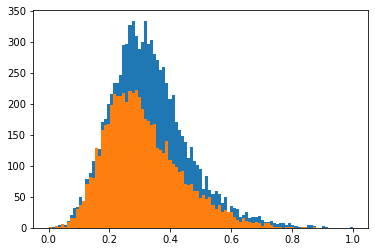

In [30]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.33164513 0.31041336
0.1282906 0.124317914


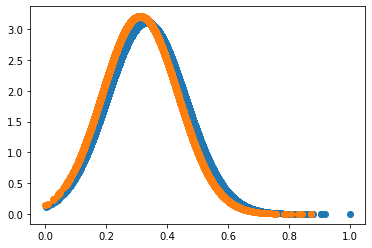

In [31]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))